C:\Users\gabriel\AppData\Local\Temp\ipykernel_24196\2980183781.py:29: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  gaussian_points = np.random.multivariate_normal(mean, cov, points_per_gaussian)


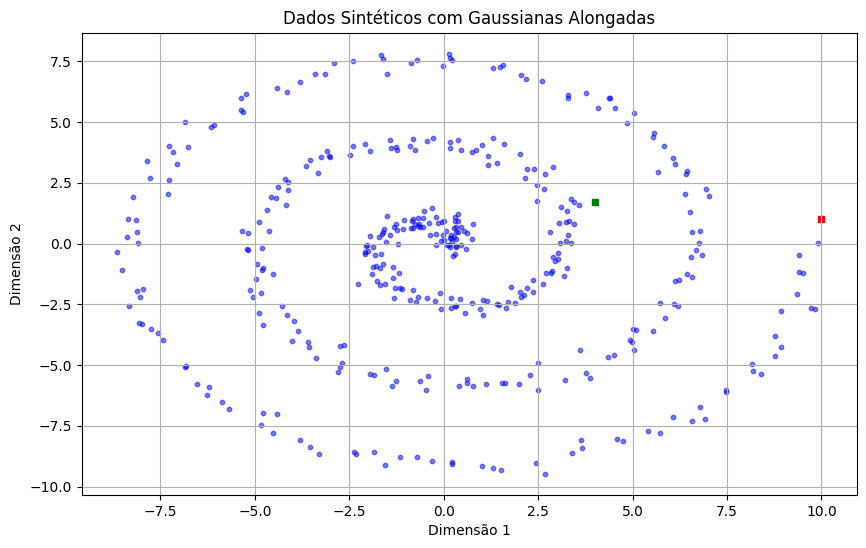

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.interpolate import interp1d

# Configurações das gaussianas
np.random.seed(42)  # Para reprodutibilidade
num_gaussians = 5
points_per_gaussian = 500

# Parâmetros de cada gaussiana (média e covariância)
means = [
    [0, 0],
    [5, 3],
    [10, 2],
    [15, 1],
]

covariances = [
    [[2, 3], [0, 0.5]],
    [[5,0], [0.2, 0.5]],
    [[3, -2], [0, 0]],
    [[1.2, 0.6], [0.6, 1]],
]

# Gerar os dados
data = []
for mean, cov in zip(means, covariances):
    gaussian_points = np.random.multivariate_normal(mean, cov, points_per_gaussian)
    data.append(gaussian_points)

data = np.vstack(data)

# Adicionar ruído
noise = np.random.normal(0, 0.2, data.shape)
data_with_noise = data + noise


def gmm_principal_curve(data, n_components=5):
    """
    Approximate a principal curve using a Gaussian Mixture Model.
    
    Parameters:
    - data: np.ndarray, shape (n_samples, n_features)
      Input data.
    - n_components: int
      Number of Gaussian components in the GMM.
    - n_points: int
      Number of points to sample on the principal curve.

    Returns:
    - curve: np.ndarray, shape (n_points, n_features)
      The computed principal curve.
    """
    # Fit GMM to the data
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(data)

    # Extract means of the GMM components
    means = gmm.means_
    covariances = gmm.covariances_
        
    # Sort means along a principal axis (e.g., first component)
    sort_indices = np.argsort(means[:, 0])
    means_sorted = means[sort_indices]
    covariances_sorted = covariances[sort_indices]
    
    ellipses = []
    curve = []
    for i, mean in enumerate(means_sorted):
        # Compute PCA on the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(covariances_sorted[i])
        
        # Take the second principal component
        std_dev0 = np.sqrt(eigvals[0]) 
        direction0 = eigvecs[:, 0]    
        std_dev1 = np.sqrt(eigvals[1]) 
        direction1 = eigvecs[:, 1]    
        
        # Scale the direction for visualization (2 * sqrt(2) * std_dev)
        scaled_direction0 = 2 * np.sqrt(2) * std_dev0 * direction0
        scaled_direction1 = std_dev1 * direction1
        
        # Save ellipse data
        ellipses.append({
            'center': mean,
            'direction': direction0,
            'scaled_direction': scaled_direction0
        })
        curve.append({
            'center': mean,
            'direction': direction1,
            'scaled_direction': scaled_direction1
        })
    
    return curve, ellipses
K = 20
import pandas as pd 
file_path = '../data/spiral_data.csv'  # Update the path if necessary
spiral_data = pd.read_csv(file_path)

# Extract x and y coordinates
x_data = spiral_data['x']
y_data = spiral_data['y']
data_with_noise = np.column_stack((x_data, y_data))
curve, ellipses = gmm_principal_curve(data_with_noise, K)

validation_data_wrong = np.array([[10, 1]]) 
validation_data_right = np.array([[4, 1.7]]) 
    
# Plotar os dados
plt.figure(figsize=(10, 6))
plt.scatter(data_with_noise[:, 0], data_with_noise[:, 1], s=10, alpha=0.5, c='blue')
plt.title("Dados Sintéticos com Gaussianas Alongadas")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.grid(True)

points_shuffled = np.zeros((2*len(ellipses), 2))
for i, ellipse in enumerate(ellipses):
    center = ellipse['center']
    scaled_direction = ellipse['scaled_direction']
    center_seg = curve[i]['center']
    scaled_direction_seg = curve[i]['scaled_direction']
    points_shuffled[2*i] = np.array([center_seg + scaled_direction_seg])
    points_shuffled[2*i+1] = np.array([center_seg - scaled_direction_seg])


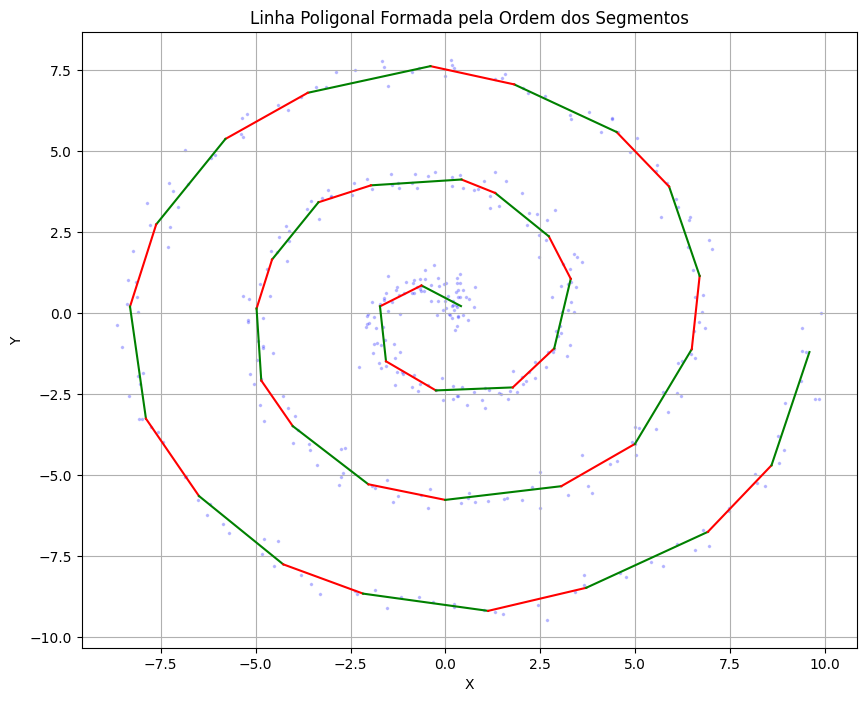

In [ ]:
from scipy import interpolate
from scipy.spatial.distance import cdist

def sampleCubicSplinesWithDerivative(points, tangents, resolution):
    '''
    Compute and sample the cubic splines for a set of input points with
    optional information about the tangent (direction AND magnitude). The 
    splines are parametrized along the traverse line (piecewise linear), with
    the resolution being the step size of the parametrization parameter.
    The resulting samples have NOT an equidistant spacing.

    Arguments:      points: a list of n-dimensional points
                    tangents: a list of tangents
                    resolution: parametrization step size
    Returns:        samples

    Notes: Lists points and tangents must have equal length. In case a tangent
           is not specified for a point, just pass None. For example:
                    points = [[0,0], [1,1], [2,0]]
                    tangents = [[1,1], None, [1,-1]]

    '''
    resolution = float(resolution)
    points = np.asarray(points)
    nPoints, dim = points.shape

    # Parametrization parameter s.
    dp = np.diff(points, axis=0)                 # difference between points
    dp = np.linalg.norm(dp, axis=1)              # distance between points
    d = np.cumsum(dp)                            # cumsum along the segments
    d = np.hstack([[0],d])                       # add distance from first point
    l = d[-1]                                    # length of point sequence
    nSamples = int(l/resolution)                 # number of samples
    s,r = np.linspace(0,l,nSamples,retstep=True) # sample parameter and step

    # Bring points and (optional) tangent information into correct format.
    assert(len(points) == len(tangents))
    data = np.empty([nPoints, dim], dtype=object)
    for i,p in enumerate(points):
        t = tangents[i]
        # Either tangent is None or has the same
        # number of dimensions as the point p.
        assert(t is None or len(t)==dim)
        fuse = list(zip(p,t) if t is not None else zip(p,))
        data[i,:] = fuse

    # Compute splines per dimension separately.
    samples = np.zeros([nSamples, dim])
    for i in range(dim):
        poly = interpolate.BPoly.from_derivatives(d, data[:,i])
        samples[:,i] = poly(s)
    return samples
# resolution = 0.2
# points = np.asarray(points)

# # Interpolate with different tangent lengths, but equal direction.
# scale = 1/K*3
# tangents = np.dot(np.asarray(tangents), scale*np.eye(2))

# samples = sampleCubicSplinesWithDerivative(points, tangents, resolution)
# M = 200
# t = np.linspace(0, len(samples[:,0]), M)
# x = np.interp(t, np.arange(len(samples[:,0])), samples[:,0])
# y = np.interp(t, np.arange(len(samples[:,1])), samples[:,1])

segments = points_shuffled.reshape(len(points_shuffled) // 2, 2, 2)
# Lista para armazenar a ordem dos segmentos
ordered_segments = []

# Usar o primeiro segmento como ponto inicial
current_segment = segments[0]
ordered_segments.append(current_segment)
current_start, current_end = current_segment

# Criar uma lista dos segmentos restantes
remaining_segments = list(segments[1:])

plt.figure(figsize=(10, 8))

while remaining_segments:
    # Criar uma lista com todos os extremos dos segmentos restantes
    candidates = []
    for seg in remaining_segments:
        candidates.extend(seg)
    candidates = np.array(candidates)
    
    # Calcular a menor distância entre o ponto final do segmento atual e os candidatos
    distances_end = cdist([current_end], candidates)
    distances_start = cdist([current_start], candidates)
    min_idx_end = np.argmin(distances_end)
    min_dist_end = np.min(distances_end)
    min_idx_start = np.argmin(distances_start)
    min_dist_start = np.min(distances_start)
    
    if min_dist_start > min_dist_end:  
        next_segment_idx = min_idx_end // 2
        next_segment = remaining_segments[next_segment_idx]
        if min_idx_end % 2 == 0:
            current_end = next_segment[1] 
            ordered_segments.append(next_segment)
        else:
            current_end = next_segment[0] 
            ordered_segments.append([next_segment[1], next_segment[0]])
              
    else:
        next_segment_idx = min_idx_start // 2
        next_segment = remaining_segments[next_segment_idx]
        if min_idx_start % 2 == 0:
            current_start = next_segment[1] 
            ordered_segments.insert(0, [next_segment[1], next_segment[0]])
        else:
            current_start = next_segment[0] 
            ordered_segments.insert(0, next_segment)
        
    # Remover o segmento já utilizado
    del remaining_segments[next_segment_idx]

# Exibir os segmentos ordenados
ordered_segments = np.array(ordered_segments)
# Plotar a linha poligonal
curve_points = []
for seg in ordered_segments:
    curve_points.append(seg[0]) 
    curve_points.append(seg[1]) 
curve_points.append(ordered_segments[-1][1]) 

curve = np.asarray(curve_points)
for i, segment in enumerate(curve):
    if i < len(curve) -1:
        plt.plot([segment[0], curve[i+1][0]], [segment[1], curve[i+1][1]], linestyle='-', color='g' if i % 2 == 0 else 'red', label='Curva')

plt.scatter(data_with_noise[:, 0], data_with_noise[:, 1], s=20, alpha=0.2, c='blue', marker='.')

plt.title('Linha Poligonal Formada pela Ordem dos Segmentos')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()